In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
from qiskit.extensions import *
from qiskit import execute
from qiskit.providers.aer import noise, QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.providers.aer.noise import NoiseModel
import math
from random import *
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
##Backends options

#takes as argument a circuit, a choice of backend (numbered), and a device name (str)
#if choice ==1, device name is irrelevant
def backend_choice(qc,choice,device_name):
    if choice == 1:
        ##simulator
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,noise_model=noise_model,shots=num).result()
        counts = result.get_counts()
        noise = noise_model
    if choice == 2:
        ##Using real machine as a backend
        provider = IBMQ.get_provider(hub='ibm-q-research')
        backend = provider.get_backend(device_name)
        device = provider.get_backend(device_name)
        result = execute(qc,backend,shots=num).result()
        counts = result.get_counts()
        noise=applyNoise(qc,device,backend)#returns noisy state counts data
    if choice == 3:
        ##Using real machines as noise model
        provider = IBMQ.get_provider(hub = 'ibm-q-research') 
        device = provider.get_backend(device_name) 
        result = execute(qc,device,noise_model=noise_model).result()
        counts=result.get_counts()
        noise=0
    if choice == 4:
        ##simulator sans noise
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=num).result()
        counts = result.get_counts()
        noise = 0
    return counts,noise

In [4]:
#Ising Hamiltonian 1: Cyclic Ring
#H= \sum_{i=1}^{N-1} \sigma^Z_i \otimes \sigma^Z_{i+1} + \sigma^Z_N \otimes \sigma^Z_1 + \sum_{i=1}^N \sigma^X_i

def Ising_ring(N,circ,t,offset=0):
    #is_circ=QuantumCircuit(N,N)
    #Using Trotterization to write Hamiltonian evolution as a profuct of evolution of each local evolution, we set r=2
    #add sigma-z terms first
    o=offset
    H_z=np.array([[np.exp(-1j*t/2),0,0,0],[0,np.exp(1j*t/2),0,0],[0,0,np.exp(1j*t/2),0],[0,0,0,np.exp(-1j*t/2)]])
    H_z=UnitaryGate(H_z)
    H_x=np.array([[np.cos(t/2),-1j*np.sin(t/2)],[-1j*np.sin(t/2),np.cos(t/2)]])
    H_x=UnitaryGate(H_x)
    for i in range(0,N-1):
        circ.append(H_z,[i+o,i+o+1])
    circ.append(H_z,[N-1+o,0+o])
    #add sigma-x terms second
    for i in range(0,N):
        circ.append(H_x,[i+o])
    H_z=np.array([[np.exp(-1j*t/2),0,0,0],[0,np.exp(1j*t/2),0,0],[0,0,np.exp(1j*t/2),0],[0,0,0,np.exp(-1j*t/2)]])
    H_z=UnitaryGate(H_z)
    H_x=np.array([[np.cos(t/2),-1j*np.sin(t/2)],[-1j*np.sin(t/2),np.cos(t/2)]])
    H_x=UnitaryGate(H_x)
    for i in range(0,N-1):
        circ.append(H_z,[i+o,i+o+1])
    circ.append(H_z,[N-1+o,0+o])
    #add sigma-x terms second
    for i in range(0,N):
        circ.append(H_x,[i+o])


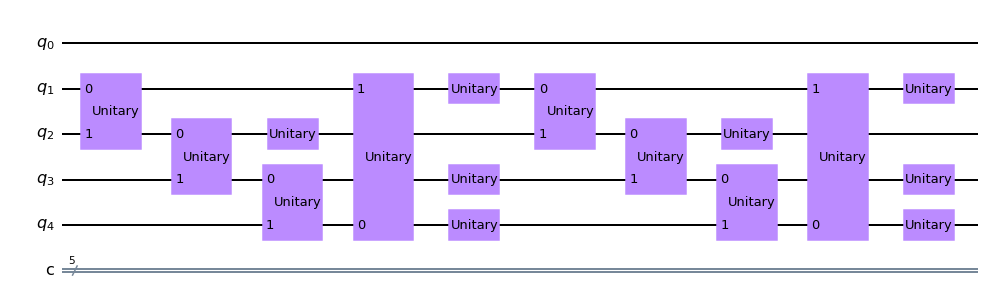

In [5]:
####Check that the ising_ring generates a circuit
N=4
test=QuantumCircuit(N+1,N+1)
Ising_ring(N,test,0.1,1)
test.draw()

In [38]:
####Testing Symmetry: 
#First: \sigma^X_1 \otimes \cdots \otimes \sigma^X_N
#Second: Cyclic shifts

#First symm uses only one, denoted c to target (first target g)
def sigma_x_symm(circ,N,g=1,c=0):
    for i in range(g,N+g):
        circ.cnot(c,i)
        
#For future use:    
def sigma_y_symm(circ,N,g=1,c=0):
    for i in range(g,N+g):
        circ.cy(c,i)
        
def sigma_z_symm(circ,N,g=1,c=0):
    for i in range(g,N+g):
        circ.cz(c,i)
    
#For cyclic shifts, it is easier to code case-by-case using binary system
        

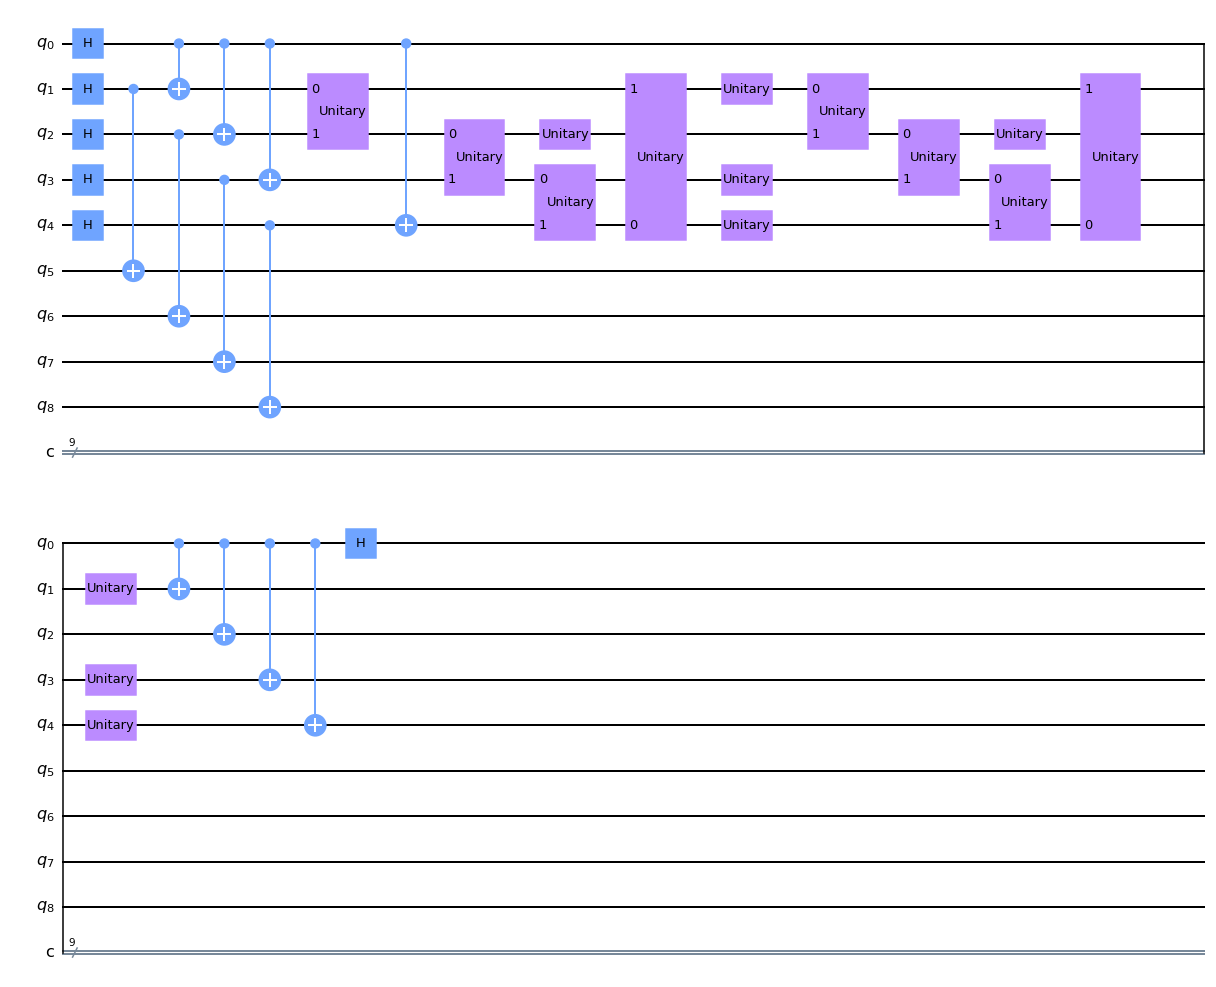

In [9]:
#A test to ensure circuit generation is working

circ=QuantumCircuit(2*N+1,2*N+1)
circ.h(0)
#create max. mixed state
for k in range(1,N+1):
    circ.h(k)
    circ.cnot(k,k+N)
#group
sigma_x_symm(circ,N)
#circuit under test
Ising_ring(N,circ,0.1,1)
#uncompute
sigma_x_symm(circ,N)
circ.h(0)
circ.draw()

In [56]:
#for 1st sym, we want to be able to parameterize the circuit by variable "t" to give time evolution
def ising_ring_param(t,N,num):
    circ=QuantumCircuit(2*N+1,2*N+1)
    circ.h(0)
    #create state#
    for k in range(1,N+1):
        circ.h(k)
        circ.cnot(k,k+N)
    
    sigma_x_symm(circ,N)
    Ising_ring(N,circ,t,1)
    sigma_x_symm(circ,N)
    circ.h(0)
    
    circ.measure(0,0)
    #tell IBM what outcome I want. No, this is not good coding.
    outcome="0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"
    outcome=outcome[:2*N+1]
    (counts,noise)=backend_choice(circ,1,'ibm_lagos')
    p=counts[outcome]/num
    return p

In [57]:
#gets data outputs as time evolves; this will allow us to plot. 
#I do many iterations of this function for different circuits
def get_time_data(num=1024):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/100
        results=ising_ring_param(t,N,num)
        t_list.append(t)
        data.append(results)
    return t_list,data

In [46]:
##For Noise##
import os
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

In [47]:
###For Noise###
backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates


print(noise_model)
print()

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['id', 'measure', 'x', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]



(0.0, 1.2)

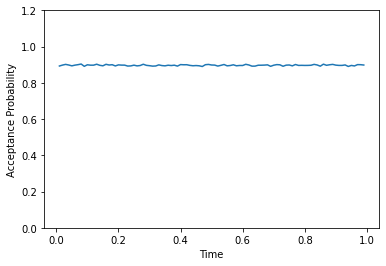

In [58]:
num=10000
results_list=get_time_data(num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.ylim(0,1.2)

In [59]:
#for 2nd sym

#cyclic group of order 3
def cyc3_ising_ring_param(t,num):
    N=3
    circ=QuantumCircuit(2*N +2,2*N +2)
    #ancilla
    circ.h(0)
    circ.cnot(0,1)
    
    #create state#
    for k in range(2,N+2):
        circ.h(k)
        circ.cnot(k,k+N)
    
    #cyclic shift on 3 qubits#
    circ.cswap(0,2,3)
    circ.cswap(0,3,4)
    circ.cswap(1,2,4)
    circ.cswap(1,2,3)
    
    #Ham evolution#
    Ising_ring(3,circ,t,2)
    
    #dagger cyclic shift#
    circ.cswap(1,2,3)
    circ.cswap(1,2,4)
    circ.cswap(0,3,4)
    circ.cswap(0,2,3)
    #uncompute
    circ.cnot(0,1)
    circ.h(0)
    
    circ.measure(0,0)
    circ.measure(1,1)
    #tell IBM what outcome I want. No, this is not efficient.
    outcome=""
    for j in np.zeros(5):
        j2=int(j)
        j2=str(j2)
        outcome += outcome+j2
    outcome=outcome[:2*N+2]
    (counts,noise)=backend_choice(circ,1,'ibm_lagos')
    p=counts[outcome]/num
    return p

#cyclic group of order 4
def cyc4_ising_ring_param(t,num):
    N=4
    circ=QuantumCircuit(2*N +2,2*N +2)
    
    #create state#
    for k in range(2,N+2):
        circ.h(k)
        circ.cnot(k,k+N)
    
    #ancilla
    circ.h(0)
    circ.h(1)
    #cyclic shift on 4 qubits#
    circ.cswap(0,2,3)
    circ.cswap(0,3,4)
    circ.cswap(0,4,5)
    circ.cswap(1,2,4)
    circ.cswap(1,3,5)
    
    #Ham evolution#
    Ising_ring(4,circ,t,2)
    
    #dagger cyclic shift#
    circ.cswap(1,3,5)
    circ.cswap(1,2,4)
    circ.cswap(0,4,5)
    circ.cswap(0,3,4)
    circ.cswap(0,2,3)
    
    #ancilla
    circ.h(0)
    circ.h(1)
    
    circ.measure(0,0)
    circ.measure(1,1)
    #tell IBM what outcome I want. No, this is not efficient.
    outcome="0000000000000000000000000000000"
    outcome=outcome[:2*N+2]
    (counts,noise)=backend_choice(circ,1,'ibm_lagos')
    p=counts[outcome]/num
    return p

In [60]:
def get_time_data_c3(num=1024):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/100
        results=cyc3_ising_ring_param(t,num)
        t_list.append(t)
        data.append(results)
    return t_list,data

def get_time_data_c4(num=1024):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/100
        results=cyc4_ising_ring_param(t,num)
        t_list.append(t)
        data.append(results)
    return t_list,data

In [ ]:
num=10000
results_list2=get_time_data_c3(num)

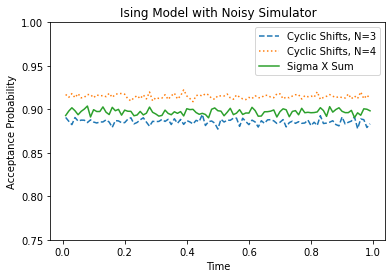

In [65]:

plt.plot(results_list2[0],results_list2[1],label='Cyclic Shifts, N=3',linestyle="dashed")
plt.plot(results_list4[0],results_list4[1],label='Cyclic Shifts, N=4',linestyle="dotted")
plt.plot(results_list[0],results_list[1],label='Sigma X Sum')
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.title('Ising Model with Noisy Simulator')
plt.ylim(0.75,1.0)
plt.legend()

Text(0, 0.5, 'Acceptance Probability')

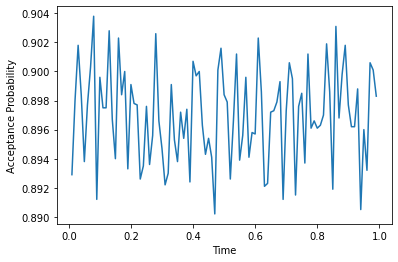

In [62]:
num=10000
results_list4=get_time_data_c4(num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

Text(0, 0.5, 'Acceptance Probability')

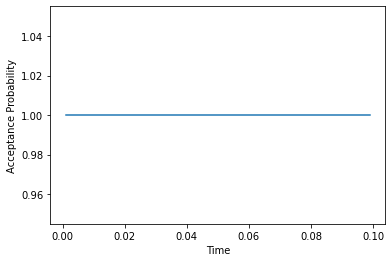

In [19]:
num=10000
results_list=get_time_data_c4(num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

Text(0, 0.5, 'Acceptance Probability')

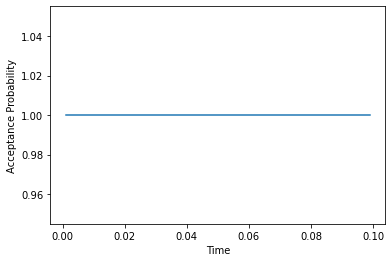

In [20]:
num=10000
results_list=get_time_data_c4(num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

In [80]:
def cyc4_test_param(t,num):
    circ=QuantumCircuit(5,5)
    #ancilla
    circ.h(0)
    #cyclic shift on 4 qubits#
    circ.cswap(0,1,2)
    circ.cswap(0,2,3)
    circ.cswap(0,3,4)
    
    #Ham evolution#
    Ising_ring(4,circ,t,1)
    
    #dagger cyclic shift#
    circ.cswap(0,3,4)
    circ.cswap(0,2,3)
    circ.cswap(0,1,2)
    
    #ancilla
    circ.h(0)
    
    circ.measure(0,0)
 
    #tell IBM what outcome I want. No, this is not efficient.
    outcome="0000000000000000000000000000000"
    outcome=outcome[:5]
    (counts,noise)=backend_choice(circ,1,'ibm_lagos')
    p=counts[outcome]/num
    return p

def get_time_test_c4(num=1024):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/1000
        results=cyc4_test_param(t,num)
        t_list.append(t)
        data.append(results)
    return t_list,data

Text(0, 0.5, 'Acceptance Probability')

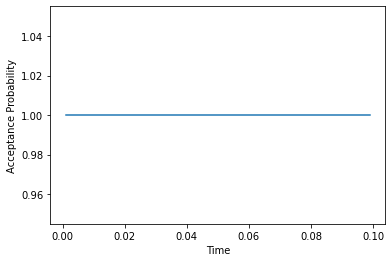

In [23]:
num=10000
results_list=get_time_test_c4(num)
plt.plot(results_list[0],results_list[1])
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')

Traceback (most recent call last):
  Input In [62] in <cell line: 2>
    plt.plot(results_list4[0],results_list4[1],label='Cyclic Shifts, N=4')
NameError: name 'results_list4' is not defined

Use %tb to get the full traceback.


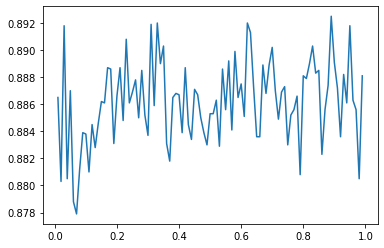

In [62]:
plt.plot(results_list2[0],results_list2[1],label='Cyclic Shifts, N=3')
plt.plot(results_list4[0],results_list4[1],label='Cyclic Shifts, N=4')
plt.plot(results_list[0],results_list[1],label='Sigma X Sum')
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.title('Ising Model with Noisy Simulator')
plt.ylim(0,1)
plt.legend()

In [23]:
#Second example: Heisenberg XY model
# H = J * \sum_{i=1}^{N-1} \sigma^x_i \otimes \sigma^x_{i+1} + \sigma^y_i \otimes \sigma^y_{i+1} 

def heisenbergXY(N,circ,t,offset=0,J=1):
    #Using Trotterization to write Hamiltonian evolution as a profuct of evolution of each local evolution
    #add sigma-x terms first
    o=offset
    H_xx=np.array([[np.cos(J*t),0,0,-1j*np.sin(J*t)],[0,np.cos(J*t),-1j*np.sin(J*t),0],[0,-1j*np.sin(J*t),np.cos(t*J),0],[-1j*np.sin(J*t),0,0,np.cos(J*t)]])
    H_xx=UnitaryGate(H_xx)
    H_yy=np.array([[np.cos(J*t),0,0,1j*np.sin(J*t)],[0,np.cos(J*t),-1j*np.sin(J*t),0],[0,-1j*np.sin(J*t),np.cos(J*t),0],[1j*np.sin(J*t),0,0,np.cos(J*t)]])
    H_yy=UnitaryGate(H_yy)
    for k in range(0,N-1):
        circ.append(H_xx,[k+o,k+o+1])
    #circ.append(H_xx,[N-1+o,0+o])#; cyclic only
    for k in range(0,N-1):
        circ.append(H_yy,[k+o,k+o+1])
    for k in range(0,N-1):
        circ.append(H_xx,[k+o,k+o+1])
    #circ.append(H_xx,[N-1+o,0+o])#; cyclic only
    for k in range(0,N-1):
        circ.append(H_yy,[k+o,k+o+1])

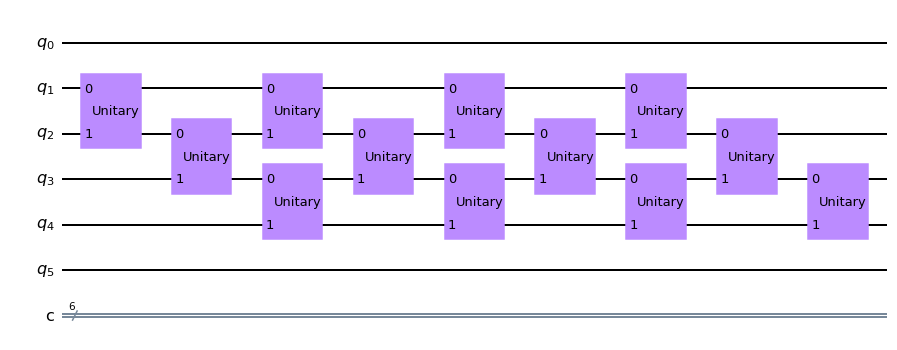

In [27]:
####Check that heisenbergXY generates a circuit
N=4
test=QuantumCircuit(N+2,N+2)
heisenbergXY(N,test,0.1,offset=1)
test.draw()

In [30]:
#According to arxiv 0101013, recover SWAP Gate for N=2, J*t=np.pi/2 so let's test that
N=2
num=10000
test=QuantumCircuit(N,N)
test.x(0)
heisenbergXY(N,test,np.pi/2,offset=0,J=1)
test.measure(0,0)
test.measure(1,1)
(counts,noise)=backend_choice(test,4,'ibm_lagos')

In [29]:
counts #input was 01

{'10': 10000}

In [31]:
counts #input was 10

{'01': 10000}

In [32]:
#controlled Hadamard
chad=HGate().control(1)

In [45]:
#This funct
def HXY_param(t,N,num,choice='x'):
    circ=QuantumCircuit(2*N+2,2*N+2)
    circ.h(0)
    circ.h(1)
    #create state#
    for k in range(2,N+2):
        circ.h(k)
        circ.cnot(k,k+N)
    #test for X,Y,Z symmetry
    sigma_x_symm(circ,N,g=2)
    sigma_y_symm(circ,N,g=2,c=1)
    
    heisenbergXY(N,circ,t,offset=2,J=1)
    
    #uncompute
    sigma_y_symm(circ,N,g=2,c=1)
    sigma_x_symm(circ,N,g=2)
    circ.h(0)
    circ.h(1)
    
    circ.measure(0,0)
    circ.measure(1,1)
    #tell IBM what outcome I want. No, this is not good coding.
    outcome="0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"
    outcome=outcome[:2*N+2]
    (counts,noise)=backend_choice(circ,1,'ibm_lagos')
    p=counts[outcome]/num
    return p

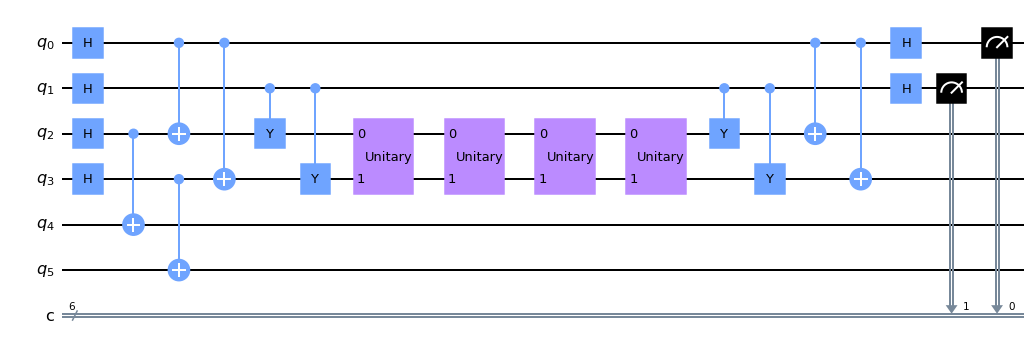

In [40]:
#Check that Heisenberg circuit generates correctly
circ=QuantumCircuit(2*N+2,2*N+2)
circ.h(0)
circ.h(1)
#create state#
for k in range(2,N+2):
    circ.h(k)
    circ.cnot(k,k+N)
sigma_x_symm(circ,N,g=2)
sigma_y_symm(circ,N,g=2,c=1)

heisenbergXY(N,circ,0.5,offset=2,J=1)

sigma_y_symm(circ,N,g=2,c=1)
sigma_x_symm(circ,N,g=2)
circ.h(0)
circ.h(1)
circ.measure(0,0)
circ.measure(1,1)
circ.draw()

In [42]:
def get_time_HXY(N,num=1024,choice='x'):
    t_list=[]
    data=[]
    for i in range(1,100):
        t=i/100
        results=HXY_param(t,N,num)
        t_list.append(t)
        data.append(results)
    return t_list,data

(0.0, 1.0)

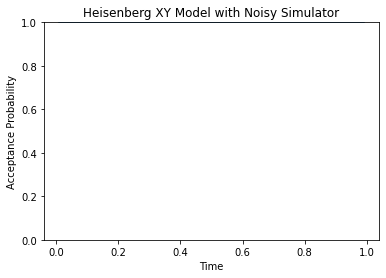

In [44]:
num=10000
results_listX=get_time_HXY(4,num)
plt.plot(results_listX[0],results_listX[1],label="Ideal Simulation")
#plt.plot(results_listY[0],results_listY[1],label="Sigma Y Conjugation")
#plt.plot(results_listZ[0],results_listZ[1],label="Sigma Z Conjugation")
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.title('Heisenberg XY Model with Noisy Simulator')
plt.ylim(0,1.1)
#plt.legend()

In [48]:
results_list_noise=get_time_HXY(4,num)

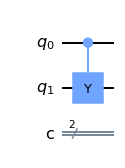

In [69]:
test=QuantumCircuit(2,2)
test.cy(0,1)
test.draw()

In [101]:
results_listY=get_time_HXY(4,num,choice='y')

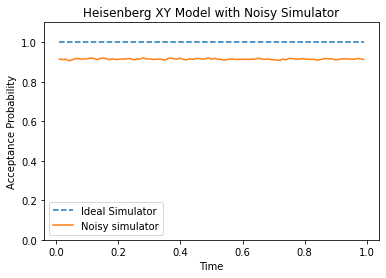

In [52]:
plt.plot(results_listX[0],results_listX[1],label="Ideal Simulator",linestyle="dashed")
plt.plot(results_list_noise[0],results_list_noise[1],label="Noisy simulator")
plt.xlabel('Time')
plt.ylabel('Acceptance Probability')
plt.title('Heisenberg XY Model with Noisy Simulator')
plt.ylim(0,1.1)
plt.legend()